# BTS On-Time Flights — EDA, Cleaning, and Feature Engineering

This notebook prepares 2024 BTS on-time performance data for downstream BI by:
- Standardizing column names and dtypes
- Cleaning nulls/sparse columns and applying schema
- Engineering features (FE1–FE6) per instructions
- Exporting a clean, sampled Parquet for analysis

## Setup & Imports
Imports used throughout; keep code readable and efficient.

In [ ]:
import os, math, re, sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# Light style for quick checks
sns.set_context('notebook')

# Utility: show small previews consistently
def preview(df, n=3):
    try:
        display(df.head(n))
    except NameError:
        return df.head(n)

preview(pd.DataFrame({'ok': [1,2,3]}))

## Globals & Configuration
Collect all tweakable variables in one place for easy modification.

In [ ]:
# Paths
DATA_DIR = Path('data')
FLIGHTS_DIR = DATA_DIR / 'flights'
DIMS_DIR = DATA_DIR / 'dims'
OUTPUT_DIR = DATA_DIR / 'output'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Cleaning configuration
SPARSE_NULL_THRESHOLD = 0.80  # drop columns with >= 80% nulls
CRITICAL_FIELDS = ['depdelayminutes', 'depdel15']  # rows missing these are dropped

# Sampling configuration (FE6)
SAMPLE_RATE = 0.10  # 10% stratified sample
RANDOM_STATE = 42
SAMPLE_KEYS = ['month', 'iata_code_reporting_airline', 'depdel15']

# Output files
OUTPUT_PARQUET = OUTPUT_DIR / 'flights_2024_clean_sampled.parquet'

# Plotting toggles (set False to skip generating figures)
SHOW_PLOTS = True

# Test mode for fast headless runs (CLI/CI)
TEST_MODE = os.environ.get('TEST_MODE', '0') == '1'
READ_NROWS = 50000 if TEST_MODE else None
if TEST_MODE:
    SHOW_PLOTS = False
print('Config — TEST_MODE:', TEST_MODE, '| READ_NROWS:', READ_NROWS)

# Helper: column standardization (lowercase; replace spaces with underscores)
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    return df

# Quick check of directories
print('Flights path exists:', FLIGHTS_DIR.exists())
print('Dims path exists:', DIMS_DIR.exists())
preview(pd.DataFrame({'flights_dir': [str(FLIGHTS_DIR)], 'dims_dir': [str(DIMS_DIR)]}))

## Discover Input Files
List available monthly CSVs and dims files.

In [ ]:
flight_files = sorted(FLIGHTS_DIR.glob('*.csv'))
dims_airport_path = DIMS_DIR / 'T_MASTER_CORD.csv'
dims_airline_path = DIMS_DIR / 'L_AIRLINE_ID.csv'

print(f'Total flight CSVs: {len(flight_files)}')
preview(pd.DataFrame({'file': [p.name for p in flight_files]}).head(3))
preview(pd.DataFrame({'dims_airport': [dims_airport_path.name], 'dims_airline': [dims_airline_path.name]}))

## Load Flights (All Months)
Load monthly CSVs, standardize column names, and concatenate. For memory safety, we defer heavy casting until after pruning.

In [4]:
def read_flight_csv(path: Path) -> pd.DataFrame:
    # Read as strings first to avoid mixed dtypes; cast later.
    df = pd.read_csv(path, dtype=str, low_memory=False, nrows=READ_NROWS)
    df = standardize_columns(df)
    return df

print('Reading', len(flight_files), 'files with nrows =', READ_NROWS)
flights_list = [read_flight_csv(p) for p in flight_files]
df = pd.concat(flights_list, ignore_index=True) if flights_list else pd.DataFrame()
print('Rows:', len(df), 'Cols:', len(df.columns))
preview(df)

Rows: 7079061 Cols: 110


,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,dot_id_reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,origin,origincityname,originstate,originstatefips,originstatename,originwac,destairportid,destairportseqid,destcitymarketid,dest,destcityname,deststate,deststatefips,deststatename,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,firstdeptime,totaladdgtime,longestaddgtime,divairportlandings,divreacheddest,divactualelapsedtime,divarrdelay,divdistance,div1airport,div1airportid,div1airportseqid,div1wheelson,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime,div2wheelsoff,div2tailnum,div3airport,div3airportid,div3airportseqid,div3wheelson,div3totalgtime,div3longestgtime,div3wheelsoff,div3tailnum,div4airport,div4airportid,div4airportseqid,div4wheelson,div4totalgtime,div4longestgtime,div4wheelsoff,div4tailnum,div5airport,div5airportid,div5airportseqid,div5wheelson,div5totalgtime,div5longestgtime,div5wheelsoff,div5tailnum,unnamed:_109
0,2024,1,1,8,1,2024-01-08,9E,20363,9E,N485PX,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0851,-5.00,0.00,0.00,-1,0800-0859,25.00,0916,1120,4.00,1135,1124,-11.00,0.00,0.00,-1,1100-1159,0.00,NaN,0.00,219.00,213.00,184.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,1,1,9,2,2024-01-09,9E,20363,9E,N912XJ,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0851,-5.00,0.00,0.00,-1,0800-0859,16.00,0907,1055,12.00,1135,1107,-28.00,0.00,0.00,-2,1100-1159,0.00,NaN,0.00,219.00,196.00,168.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,1,1,10,3,2024-01-10,9E,20363,9E,N918XJ,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0850,-6.00,0.00,0.00,-1,0800-0859,17.00,0907,1104,6.00,1135,1110,-25.00,0.00,0.00,-2,1100-1159,0.00,NaN,0.00,219.00,200.00,177.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Quick EDA: Missingness & Basic Sanity
Understand nulls to inform pruning and dtype casting.

In [5]:
if not df.empty:
    missing_frac = df.isna().mean().sort_values(ascending=False)
    preview(missing_frac.to_frame('missing_frac'))
    preview(df[['flightdate','month','origin','dest','crsdeptime','deptime','depdelay','depdelayminutes','depdel15']].head(3))
else:
    preview(pd.DataFrame({'note': ['no data loaded']}))

,missing_frac
unnamed:_109,1.0
div4tailnum,1.0
div4airport,1.0


,flightdate,month,origin,dest,crsdeptime,deptime,depdelay,depdelayminutes,depdel15
0,2024-01-08,1,LGA,OMA,0856,0851,-5.00,0.00,0.00
1,2024-01-09,1,LGA,OMA,0856,0851,-5.00,0.00,0.00
2,2024-01-10,1,LGA,OMA,0856,0850,-6.00,0.00,0.00


## DE1: Drop Rows Missing Critical Fields
Remove rows where `depdelayminutes` or `depdel15` is null/blank.

In [6]:
def drop_critical_nulls(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in CRITICAL_FIELDS:
        if c in df.columns:
            df[c] = df[c].replace('', np.nan)
            df = df[df[c].notna()]
    return df

before = len(df)
df = drop_critical_nulls(df)
after = len(df)
print('Dropped rows (critical nulls):', before - after, 'Remaining:', after)
preview(df.head(3))

Dropped rows (critical nulls): 92970 Remaining: 6986091


,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,dot_id_reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,origin,origincityname,originstate,originstatefips,originstatename,originwac,destairportid,destairportseqid,destcitymarketid,dest,destcityname,deststate,deststatefips,deststatename,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,firstdeptime,totaladdgtime,longestaddgtime,divairportlandings,divreacheddest,divactualelapsedtime,divarrdelay,divdistance,div1airport,div1airportid,div1airportseqid,div1wheelson,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime,div2wheelsoff,div2tailnum,div3airport,div3airportid,div3airportseqid,div3wheelson,div3totalgtime,div3longestgtime,div3wheelsoff,div3tailnum,div4airport,div4airportid,div4airportseqid,div4wheelson,div4totalgtime,div4longestgtime,div4wheelsoff,div4tailnum,div5airport,div5airportid,div5airportseqid,div5wheelson,div5totalgtime,div5longestgtime,div5wheelsoff,div5tailnum,unnamed:_109
0,2024,1,1,8,1,2024-01-08,9E,20363,9E,N485PX,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0851,-5.00,0.00,0.00,-1,0800-0859,25.00,0916,1120,4.00,1135,1124,-11.00,0.00,0.00,-1,1100-1159,0.00,NaN,0.00,219.00,213.00,184.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,1,1,9,2,2024-01-09,9E,20363,9E,N912XJ,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0851,-5.00,0.00,0.00,-1,0800-0859,16.00,0907,1055,12.00,1135,1107,-28.00,0.00,0.00,-2,1100-1159,0.00,NaN,0.00,219.00,196.00,168.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,1,1,10,3,2024-01-10,9E,20363,9E,N918XJ,4801,12953,1295304,31703,LGA,"New York, NY",NY,36,New York,22,13871,1387102,33316,OMA,"Omaha, NE",NE,31,Nebraska,65,0856,0850,-6.00,0.00,0.00,-1,0800-0859,17.00,0907,1104,6.00,1135,1110,-25.00,0.00,0.00,-2,1100-1159,0.00,NaN,0.00,219.00,200.00,177.00,1.00,1148.00,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DE2: Drop Sparse Columns (>= 80% Nulls)
Prune legacy/unused fields. Threshold configurable via `SPARSE_NULL_THRESHOLD`.

In [7]:
def drop_sparse_columns(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    frac = df.isna().mean()
    to_drop = frac[frac >= threshold].index.tolist()
    print(f'Dropping {len(to_drop)} sparse columns (>= {threshold:.0%} nulls)')
    return df.drop(columns=to_drop)

df = drop_sparse_columns(df, SPARSE_NULL_THRESHOLD)
preview(pd.Series(df.columns[:12]))

Dropping 49 sparse columns (>= 80% nulls)


0       year
1    quarter
2      month
dtype: object

## DE3: Dtype Casting per Dictionary/Best Guess
Set canonical types for key fields; parse dates and numeric fields.

In [8]:
def to_int(series):
    return pd.to_numeric(series, errors='coerce').astype('Int64')

def to_float(series):
    return pd.to_numeric(series, errors='coerce').astype(float)

# Parse date
if 'flightdate' in df.columns:
    df['flightdate'] = pd.to_datetime(df['flightdate'], errors='coerce')

# Numeric casts for key fields
for c in ['year','quarter','month','dayofmonth','dayofweek','originairportid','destairportid','dot_id_reporting_airline']:
    if c in df.columns:
        df[c] = to_int(df[c])

for c in ['depdelay','depdelayminutes','arrdelay','arrdelayminutes','taxiout','taxiin','airtime','distance']:
    if c in df.columns:
        df[c] = to_float(df[c])

# Keep string/object for codes
for c in ['origin','dest','iata_code_reporting_airline','reporting_airline','tail_number']:
    if c in df.columns:
        df[c] = df[c].astype('string')

preview(df[['flightdate','month','origin','dest','depdelayminutes','depdel15']].head(3))

,flightdate,month,origin,dest,depdelayminutes,depdel15
0,2024-01-08,1,LGA,OMA,0.0,0.00
1,2024-01-09,1,LGA,OMA,0.0,0.00
2,2024-01-10,1,LGA,OMA,0.0,0.00


## FE1: Day-Part (Scheduled and Actual) with Midnight Rollover
Create `daypart_sched` from `crsdeptime` and `daypart_actual` from `deptime` with rollover handling.

In [9]:
# FE1: Day-Part (Scheduled and Actual) with Midnight Rollover (vectorized)
import numpy as np
import pandas as pd

DAYPART_ORDER = ['night','early_morning','morning','afternoon','late_afternoon','evening']
DAYPART_CAT = pd.CategoricalDtype(categories=DAYPART_ORDER, ordered=True)

def _extract_hour_min(series: pd.Series):
    # Convert to string, strip, and sanitize
    s = series.astype('string').str.strip()
    s = s.str.split('.', n=1).str[0]  # drop fractional suffixes like '856.00'
    s_digits = s.str.replace(r'[^0-9]', '', regex=True)
    s_digits = s_digits.where(s_digits.str.len() > 0)
    s4 = s_digits.str.zfill(4)

    hh = pd.to_numeric(s4.str[:2], errors='coerce')
    mm = pd.to_numeric(s4.str[2:], errors='coerce')

    # Normalize edge cases: 2400 -> 00:00; clamp to valid ranges
    is_2400 = s4 == '2400'
    hh = hh.clip(0, 23).mask(is_2400, 0).astype('Int64')
    mm = mm.clip(0, 59).mask(is_2400, 0).astype('Int64')
    return hh, mm

def _to_daypart(hour: pd.Series) -> pd.Series:
    h = hour.astype('float64')
    buckets = pd.cut(
        h,
        bins=[-0.1, 3, 7, 11, 15, 19, 23],
        labels=DAYPART_ORDER,
        include_lowest=True,
        right=True,
    )
    return buckets.astype(DAYPART_CAT)

def compute_dayparts_fast(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    if 'crsdeptime' in out:
        crs_h, _ = _extract_hour_min(out['crsdeptime'])
        out['daypart_sched'] = _to_daypart(crs_h)
    else:
        out['daypart_sched'] = pd.Series(pd.Categorical([np.nan] * len(out), categories=DAYPART_ORDER), index=out.index)

    if 'deptime' in out:
        dep_h, _ = _extract_hour_min(out['deptime'])
        out['daypart_actual'] = _to_daypart(dep_h)
    else:
        out['daypart_actual'] = pd.Series(pd.Categorical([np.nan] * len(out), categories=DAYPART_ORDER), index=out.index)

    return out

df = compute_dayparts_fast(df)
preview(df[['flightdate','crsdeptime','deptime','daypart_sched','daypart_actual']].head(3))

,flightdate,crsdeptime,deptime,daypart_sched,daypart_actual
0,2024-01-08,0856,0851,morning,morning
1,2024-01-09,0856,0851,morning,morning
2,2024-01-10,0856,0850,morning,morning


## FE2: Origin Airport Tiers (Top 20%, Next 50%, Bottom 30%)
Group by `origin` across all flights (including cancelled); assign tiers by airport percentiles.

In [10]:
def assign_origin_tiers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    counts = df.groupby('origin', dropna=False).size().reset_index(name='flights')
    counts = counts.sort_values(['flights','origin'], ascending=[False, True]).reset_index(drop=True)
    counts['airport_rank'] = np.arange(1, len(counts)+1)
    counts['airport_pct'] = counts['airport_rank'] / len(counts)
    def tier(p):
        if p <= 0.20: return 'Tier 1'
        if p <= 0.70: return 'Tier 2'
        return 'Tier 3'
    counts['origin_tier'] = counts['airport_pct'].apply(tier)
    return df.merge(counts[['origin','origin_tier']], on='origin', how='left')

df = assign_origin_tiers(df)
preview(df[['origin','origin_tier']].head(3))

,origin,origin_tier
0,LGA,Tier 1
1,LGA,Tier 1
2,LGA,Tier 1


## FE3: Late/On-Time Flags
Create `is_late_departure` from `depdel15` and `is_on_time_departure = 1 - is_late_departure`.

In [11]:
def add_departure_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['depdel15'] = pd.to_numeric(df['depdel15'], errors='coerce')
    df['is_late_departure'] = (df['depdel15'] == 1).astype('Int8')
    df['is_on_time_departure'] = (1 - df['is_late_departure'].fillna(0)).astype('Int8')
    return df

df = add_departure_flags(df)
preview(df[['depdel15','depdelayminutes','is_late_departure','is_on_time_departure']].head(3))

,depdel15,depdelayminutes,is_late_departure,is_on_time_departure
0,0.0,0.0,0,1
1,0.0,0.0,0,1
2,0.0,0.0,0,1


## FE4: Airport Coordinates (Origin/Dest)
Join `T_MASTER_CORD.csv` on airport IDs, filter `airport_is_latest == 1`, and keep only lat/long.

In [12]:
airports = pd.read_csv(dims_airport_path, dtype=str)
airports = standardize_columns(airports)
airports = airports[airports['airport_is_latest'] == '1']
airports = airports[['airport_id','latitude','longitude']].copy()
airports['airport_id'] = pd.to_numeric(airports['airport_id'], errors='coerce').astype('Int64')
airports['latitude'] = pd.to_numeric(airports['latitude'], errors='coerce')
airports['longitude'] = pd.to_numeric(airports['longitude'], errors='coerce')

df = df.merge(airports.rename(columns={'airport_id':'originairportid', 'latitude':'origin_lat', 'longitude':'origin_long'}),
               on='originairportid', how='left')
df = df.merge(airports.rename(columns={'airport_id':'destairportid', 'latitude':'dest_lat', 'longitude':'dest_long'}),
               on='destairportid', how='left')
preview(df[['origin','origin_lat','origin_long','dest','dest_lat','dest_long']].head(3))

,origin,origin_lat,origin_long,dest,dest_lat,dest_long
0,LGA,40.777222,-73.8725,OMA,41.303056,-95.893889
1,LGA,40.777222,-73.8725,OMA,41.303056,-95.893889
2,LGA,40.777222,-73.8725,OMA,41.303056,-95.893889


## FE5: Airline Name (Join on IATA Code)
Parse IATA code and airline name from `L_AIRLINE_ID.csv` descriptions, then join to flights.

In [13]:
airlines = pd.read_csv(dims_airline_path, dtype=str)
airlines = standardize_columns(airlines)
# Expect columns: 'code' (numeric id), 'description' like 'Southwest Airlines Co.: WN'
def split_airline_desc(s):
    if pd.isna(s):
        return pd.Series({'airline_name': np.nan, 'iata_code': np.nan})
    parts = str(s).split(':')
    if len(parts) >= 2:
        name = parts[0].strip()
        code = parts[1].strip()
        return pd.Series({'airline_name': name, 'iata_code': code})
    return pd.Series({'airline_name': str(s).strip(), 'iata_code': np.nan})

airlines[['airline_name','iata_code']] = airlines['description'].apply(split_airline_desc)
airlines['iata_code'] = airlines['iata_code'].str.upper()
airline_lookup = airlines[['iata_code','airline_name']].dropna(subset=['iata_code']).drop_duplicates()

df = df.merge(airline_lookup, left_on='iata_code_reporting_airline', right_on='iata_code', how='left')
df = df.drop(columns=['iata_code'])
preview(df[['iata_code_reporting_airline','airline_name']].head(3))

,iata_code_reporting_airline,airline_name
0,9E,Endeavor Air Inc.
1,9E,Endeavor Air Inc.
2,9E,Endeavor Air Inc.


## FE6: Stratified Down-Sampling (10%)
Stratify by `month`, `iata_code_reporting_airline`, and `depdel15` to preserve seasonality, carrier mix, and delay balance.

In [14]:
def stratified_sample(df: pd.DataFrame, keys, frac: float, random_state: int) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)
    def take_sample(g):
        n = len(g)
        k = max(1, int(math.ceil(n * frac)))
        return g.sample(n=min(k, n), random_state=random_state, replace=False)
    return df.groupby(keys, dropna=False, as_index=False, group_keys=False).apply(take_sample)

df_sampled = stratified_sample(df, SAMPLE_KEYS, SAMPLE_RATE, RANDOM_STATE) if not df.empty else df
print('Sampled rows:', len(df_sampled), 'out of', len(df))
preview(df_sampled[['month','iata_code_reporting_airline','depdel15']].head(3))

Sampled rows: 698771 out of 6986091


/var/folders/gk/zmj73pwn5k7cp0b6dk9t9mrw0000gn/T/ipykernel_13488/565455739.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(keys, dropna=False, as_index=False, group_keys=False).apply(take_sample)


,month,iata_code_reporting_airline,depdel15
962,1,9E,0.0
12975,1,9E,0.0
465,1,9E,0.0


## DE6: Final Cleanup
Drop redundant and ambiguous columns (e.g., raw flags, IDs used only for joins), keeping BI-useful fields.

In [15]:
UNWANTED_COLS = [
    # Airline/carrier identifiers duplicated by joins
    'tail_number', 'depdel15', 'reporting_airline', 'dot_id_reporting_airline', 'iata_code_reporting_airline',
    # Airport/location IDs used only for joins (keep IATA codes + lat/long)
    'originairportid', 'destairportid', 'originairportseqid', 'destairportseqid',
    'origincitymarketid', 'destcitymarketid', 'originwac', 'destwac'
]  # extend as needed

def drop_unwanted(df: pd.DataFrame, cols) -> pd.DataFrame:
    existing = [c for c in cols if c in df.columns]
    print('Dropping unwanted cols:', existing)
    return df.drop(columns=existing)

df_final = drop_unwanted(df_sampled, UNWANTED_COLS)
preview(pd.Series(sorted(df_final.columns)).head(12))

Dropping unwanted cols: ['tail_number', 'depdel15', 'reporting_airline', 'dot_id_reporting_airline', 'iata_code_reporting_airline', 'originairportid', 'destairportid', 'originairportseqid', 'destairportseqid', 'origincitymarketid', 'destcitymarketid', 'originwac', 'destwac']


0    actualelapsedtime
1         airline_name
2              airtime
dtype: object

# Remove More Unwanted Columns

In [18]:
more_unwanted = ['daypart_sched', 'airtime', 'actualelapsedtime', 'crselapsedtime', 
                 'arrtimeblk', 'arrivaldelaygroups', 'deptimeblk', 'departuredelaygroups', 'depdelay', 'crsdeptime'
                 , 'originstatefips', 'deststatefips']

df_final = drop_unwanted(df_final, more_unwanted)

Dropping unwanted cols: ['daypart_sched', 'airtime', 'actualelapsedtime', 'crselapsedtime', 'arrtimeblk', 'arrivaldelaygroups', 'deptimeblk', 'departuredelaygroups', 'depdelay', 'crsdeptime', 'originstatefips', 'deststatefips']


## Export to Parquet
Write the engineered, sampled dataset to `data/output`.

In [19]:
df_final.to_parquet(OUTPUT_PARQUET, index=False)
preview(pd.DataFrame({'written_to': [str(OUTPUT_PARQUET)]}))

,written_to
0,data/output/flights_2024_clean_sampled.parquet


## Validation Visuals
Quick plots to sanity-check distributions and feature derivations.

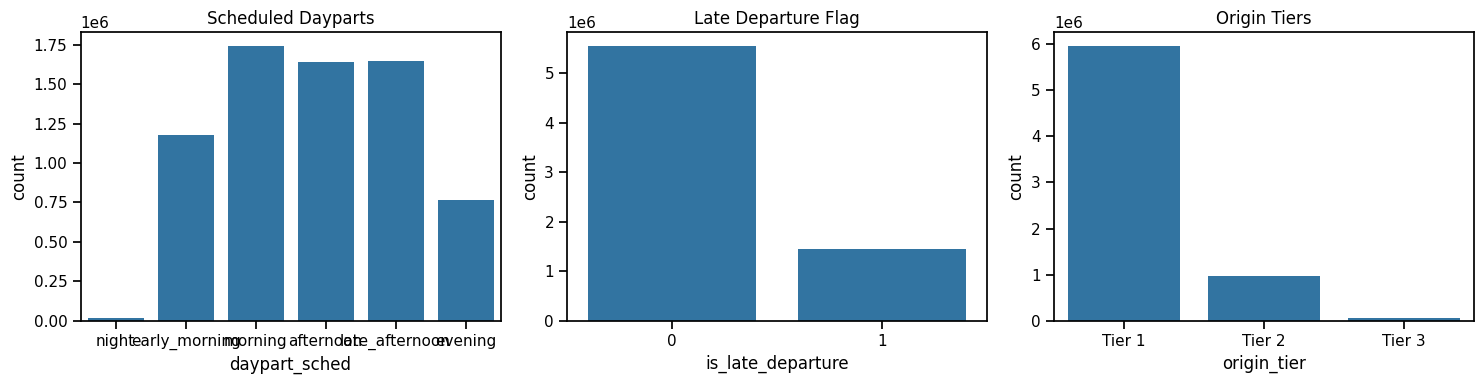

,daypart_sched,is_late_departure,origin_tier
0,morning,0,Tier 1
1,morning,0,Tier 1
2,morning,0,Tier 1


In [20]:
if SHOW_PLOTS and not df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    sns.countplot(data=df, x='daypart_sched', ax=axes[0], order=['night','early_morning','morning','afternoon','late_afternoon','evening'])
    axes[0].set_title('Scheduled Dayparts')
    sns.countplot(data=df, x='is_late_departure', ax=axes[1])
    axes[1].set_title('Late Departure Flag')
    sns.countplot(data=df, x='origin_tier', ax=axes[2], order=['Tier 1','Tier 2','Tier 3'])
    axes[2].set_title('Origin Tiers')
    plt.tight_layout()
    plt.show()
    preview(df[['daypart_sched','is_late_departure','origin_tier']].head(3))
else:
    preview(pd.DataFrame({'note': ['plots skipped or no data']}))